# Example of Linear Regression using GapMinder Data

As a very simple example of machine learning we're going see if we can predict life expectancy using some data from [GapMinder](https://www.gapminder.org/tools/#_data_/_lastModified:1526038652718&lastModified:1526038652718;&chart-type=bubbles), and organisation that aims to educate us more on the true state of the world.
The input data set will have the following variables:
- Country - 136 countries are included 
- Continent
- Life expectancy
- GDP per capita, PPP, inflation adjusted health_spend
- Healthcare spend as a percentage of GDP
- Popultaion per square km 
- The democracy index of the country (high is better). See https://en.wikipedia.org/wiki/Democracy_Index

Go to [GapMinder](https://www.gapminder.org/tools/#_data_/_lastModified:1526038652718&lastModified:1526038652718;&chart-type=bubbles) now and take a look at some of these variable in the data viewer.  Do any of the variables (visually) look like they have a bearing on life expectancy?  Are any of them surprising?
<img src="files/Screen Shot from gapminder.png" alt="GDP per Capita vs. Life Expectancy from Gapminder" title="GDP per Capita vs. Life Expectancy from Gapminder" style="width: 50pc;"/>

# Basic Linear Regression Theory
- Straight line equation (indicate dependent vs. independent variable)
- Least squares
- Expand to multiple dimensions
- Link to more detailed explanation

# How do we know which variables to use?
## Backward elimination
1. Choose a maximum P value: 5% is a good value
2. Run the linear regression using all the dependent variables. 
3. Look at the P values from the output, and choose the biggest.  
4. If it is > than 5%, then drop that variable.
5. Rerun the linear regression.
6. Repeat steps 2-5 until all P-values are < 5%.  

# Coding
## Importing the Dataset
Firstly we need to import some libraries

In [7]:
# Standard library for numerical analysis
import numpy as np
# Standard library for data manipulation
import pandas as pd
# User-defined library for making plots
from plot_functions import make_plot

Next we will import the dataset with data for 2007, which has the following columns:
Country - 136 countries are included
Continent
lifeexp - Life expectancy
gdpPercap - GDP per capita, PPP, inflation adjusted
health_spend - Healthcare spend as a percentage of GDP
Pop density - popultaion per square km
Democracy - The democracy index of the country (high is better).  See https://en.wikipedia.org/wiki/Democracy_Index

In [11]:
dataset = pd.read_csv('datasets/gapminder_2007_emma.csv')

### Here is how the data looks:

<img src="files/Screen Shot dataset.png" alt="Data_table" title="Data table" style="width: 50pc;"/>



### Data preparation
To get ready for the regression we need to make sure that all the columns contain numbers only:
- Cells that are empty currently contain "Not a Number" (nan) - these will be replaced with an average
- Cells that contain words ("categorical variables") will be replaced with numerical values.

But firstly the data now needs to be split into independent and dependent variables:

In [12]:
# Country, continent, population, GDP per cap, healthcare spend, pop density, democracy
X = dataset.iloc[:,[0,1,3,4,5,6,7]].values
# Will use the log of the GDP per capita because from our first look, there seems to be a log-linear realtionship
X[:,3] = np.log(dataset.iloc[:,4].values)
# The dependent variable is life expectancy, in column 2
y = dataset.iloc[:, 2].values
# Also making a list of continents for plotting purposes
cont = dataset.iloc[:,1].values

## Cleaning
- The cells where data is missing have "Not a Number" in them. The following code replaces these with the average for that column

In [13]:
# Fix the "NaNs" - replace with the average of that column
# sklearn contains libraries for preprocessing data
# now importing Imputer class
from sklearn.preprocessing import Imputer
# Create object
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
# Fit imputer object to feature X
imputer = imputer.fit(X[:,2:])
# Replace missing data with replaced values
X[:,2:] = imputer.transform(X[:,2:])

## Categorical variables
Categorical variables are ones which have a name, not a number.  In this case that would "Country name" and "Continent".

__Country name__: We only have each country listed once, and it makes no sense to use the name of the country in the regression, so we are somply going to number them 0-136

__Continent__: There are 5 continents in this dataset: Africa, Americas, Asia, Europe and Oceania.  If we simply give them a number 0-4, Python will assume that Oceania "is greater" than all this other continents, which makes no sense.  To fix this we use "one-hot encoding" which works like this:
- Number the continents 0-4
- Create a column for each continent -- these new columns are called "dummy variables"
- If the country is in that continent the column contains "1" otherwise it contains "0"
- Finally, since any of the five columns could be predicted from the other four (known as the "dummy variable trap") we need to drop one.
    - Normally it would be the first column, but since Africa looks quite interesting in this dataset, I decided to drop Oceania


In [14]:
# now importing LabelEncoder and OneHotEncoder classes
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Encoding the Independent Variable
# Firstly assign the categorical variables a unique number using LabelEncoder
labelencoder_X = LabelEncoder()
# Country names are in column zero
# Each country will get a number 0-136 (for the full dataset) 
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
# Each continent will get a number 0-4
X[:, 1] = labelencoder_X.fit_transform(X[:, 1])
cont = labelencoder_X.fit_transform(cont)

# one hot encode continenets
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
# Remove a continent (dummy variable trap)
# The obvious one to drop is Africa as it's the first column
# However this is also the most interesting
# so dropping Oceania instead
X = X[:,[0,1,2,3,5,6,7,8,9,10]]

# Add a column of ones to the begining.  
# This is because the following procedure 
# will otherwise not have a constant in the regression model
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test, cont_train, cont_test = train_test_split(X, y, cont, test_size = 0.2, random_state = 0)

"""
Columns are now
0: constant, 1:is Africa 2: is Americas 3: is Asia 4:is Europe
5: country 6:population 7:log(GDP per cap) 
8:health spend 9:pop density 10: dempocracy score
"""

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'\nColumns are now\n0: constant, 1:is Africa 2: is Americas 3: is Asia 4:is Europe\n5: country 6:population 7:log(GDP per cap) \n8:health spend 9:pop density 10: dempocracy score\n'

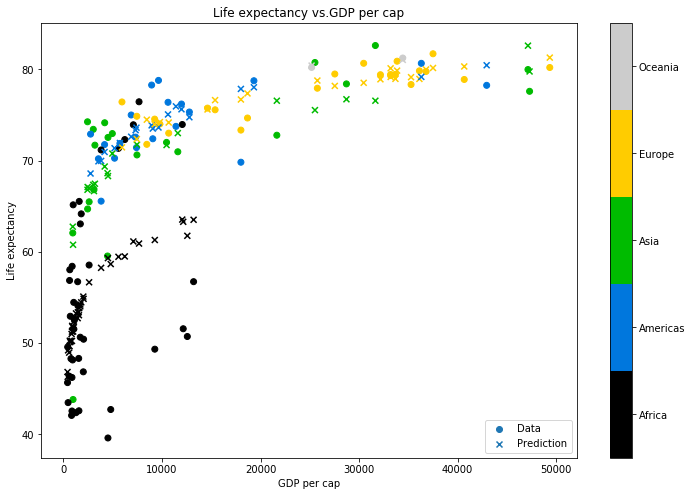

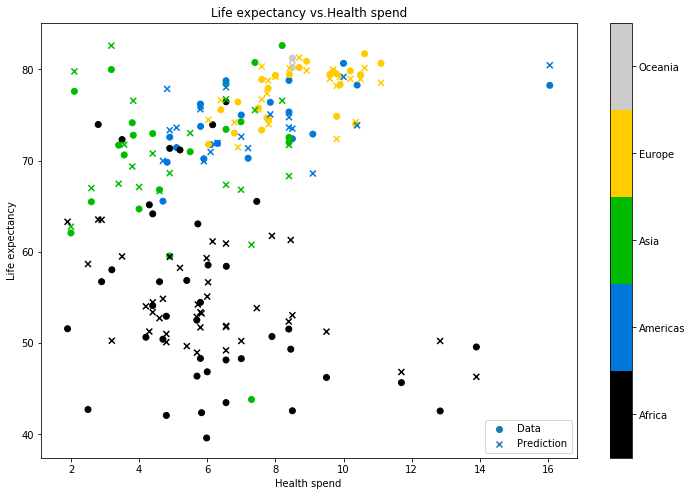

In [17]:
"""Start the training
"""

#train the regressor
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
#Make predictions
y_pred = regressor.predict(X_train)

#plot the results
gdp_per_cap = np.exp(X_train[:,7])
make_plot('GDP per cap',gdp_per_cap,y_train,y_pred,cont_train)
#plot the results
make_plot('Health spend',X_train[:,8],y_train,y_pred,cont_train)


In [18]:
#Start backward elimination
import statsmodels.formula.api as sm
X_opt = X_train[ : , [0,1,2,3,4,5,6,7,8,9,10]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     28.69
Date:                Tue, 15 May 2018   Prob (F-statistic):           9.53e-25
Time:                        16:46:33   Log-Likelihood:                -351.40
No. Observations:                 108   AIC:                             724.8
Df Residuals:                      97   BIC:                             754.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.5923      9.214      3.972      0.000      18.306      54.879
x1           -15.0632      5.374     -2.803      0.006     -25.728      -4.398
x2            -2.0509      5.012     -0.409      0.683     -11.998       7.896
x3            -4.9746      5.329     -0.934      0.353     -15.551       5.602
x4            -2.0982      4.883     -0.430      0.668     -11.790       7.593
x5             0.0094      0.016      0.584      0.561      -0.023       0.042
x6           1.27e-09   4.07e-09      0.312      0.756   -6.81e-09    9.35e-09
x7             4.4054      0.715      6.161      0.000       2.986       5.825
x8            -0.1395      0.300     -0.465      0.643      -0.735       0.455
x9             0.0004      0.001      0.409      0.684      -0.002       0.003
x10           -0.0470      0.139     -0.337      0.736      -0.323       0.229
==============================================================================
Omnibus:                        4.983   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                5.722
Skew:                          -0.230   Prob(JB):                       0.0572
Kurtosis:                       4.029   Cond. No.                     3.40e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""